In [2]:
import tensorflow as tf
print(tf.__version__)  # Check TensorFlow version
print("GPU Available: ", tf.config.list_physical_devices('GPU'))  # Check if TensorFlow is using GPU

2.8.0
GPU Available:  []


2024-06-13 10:48:59.730371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-13 10:48:59.793512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib/:/usr/local/cuda-12.5/lib64:/usr/local/cuda/extras/CUPTI/lib64:
2024-06-13 10:48:59.793540: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import umap

import matplotlib.pyplot as plt
import matplotlib
 
import pickle as pk
import h5py

import scanpy as sc
from VITAE import load_data,VITAE

2024-06-13 11:11:35.837516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 11:11:36.950746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load data
adata_crinier = sc.read_h5ad('/home/biocodingbarbie/OneDrive/PhD/Public datasets/NK studies datasets/adata_crinier_post_scvi.h5ad')

/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
umap_scvi = adata_crinier.obsm['X_umap'].copy()

In [4]:
adata_crinier

AnnData object with n_obs × n_vars = 24296 × 12049
    obs: 'Sample', 'Study', 'Sequencing_depth', 'Organ', 'Cell labels', '_scvi_batch', '_scvi_labels', 'leiden'
    uns: 'Cell labels_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'scVI normalised'
    obsp: 'connectivities', 'distances'

In [5]:
# preprocessing the data
sc.pp.normalize_total(adata_crinier, target_sum=1e4)
sc.pp.log1p(adata_crinier)
sc.pp.highly_variable_genes(adata_crinier, min_mean=0.0125, max_mean=3, min_disp=0.5)


sc.pp.scale(adata_crinier, max_value=10)

sc.tl.pca(adata_crinier, svd_solver='arpack')
sc.pp.neighbors(adata_crinier, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_crinier)

/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


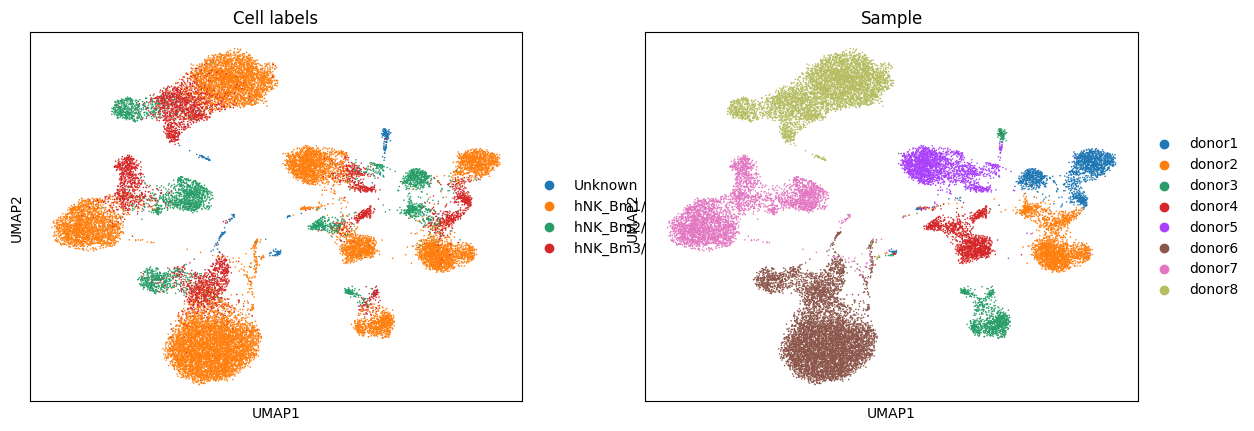

In [6]:
sc.pl.umap(adata_crinier, color=['Cell labels', 'Sample'])

In [7]:
# building the vitae model, neural net

model = VITAE(adata = adata_crinier, 
        hidden_layers = [32, 16],
        latent_space_dim = 8,
        model_type = 'Gaussian',
             covariates = ['Sample'])

2024-06-13 11:12:45.135852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-13 11:12:45.245180: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
# pre-train model
model.pre_train(learning_rate=1e-3,L = 1)

 88/200 [============>.................] - ETA: 6:58Best Epoch: 76. Best Metric: 100.532509.
Early stopping.
Pretrain Done.


Merge clusters for cluster centers that are too close ...
Merge 6,9
Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.
Calculate UMAP ...


/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


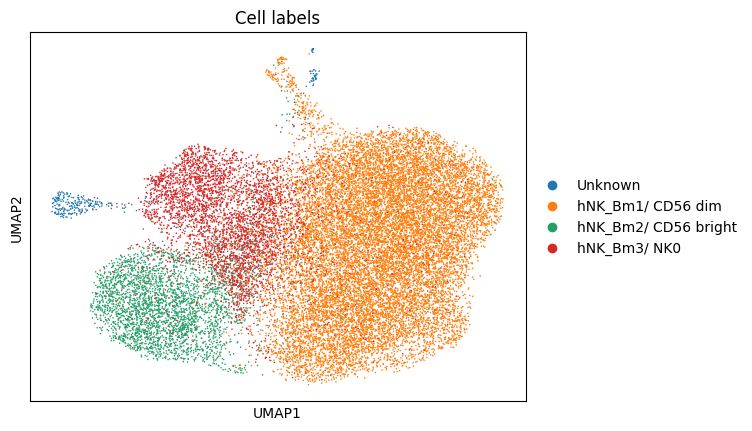

In [9]:
# Use grouping information from adata to initialize the clusters:
model.init_latent_space(cluster_label= 'leiden', res = 0.4) 
# If the input adata contain other cluster labels, such as 'leiden', simply change the above to:
#     model.init_latent_space(cluster_label = 'leiden')
# If no cluster labels are availabvle, simply set it to be None and leiden clustering will be performed:
#    model.init_latent_space(cluster_label = None)


model.visualize_latent(color=['Cell labels'])

In [10]:
# training model
model.train(early_stopping_tolerance = 0.01, beta = 1, early_stopping_relative = True)

Warmup:0
 40/200 [=====>........................] - ETA: 14:39Best Epoch: 28. Best Metric: 110.377304.
Early stopping.
Training Done!


In [11]:
model.posterior_estimation(batch_size=32, L=100)

Computing posterior estimations over mini-batches.
760/760 [==============================] - 338s 444ms/step
New clustering labels saved as 'vitae_new_clustering' in self.adata.obs.


Calculate UMAP ...


/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


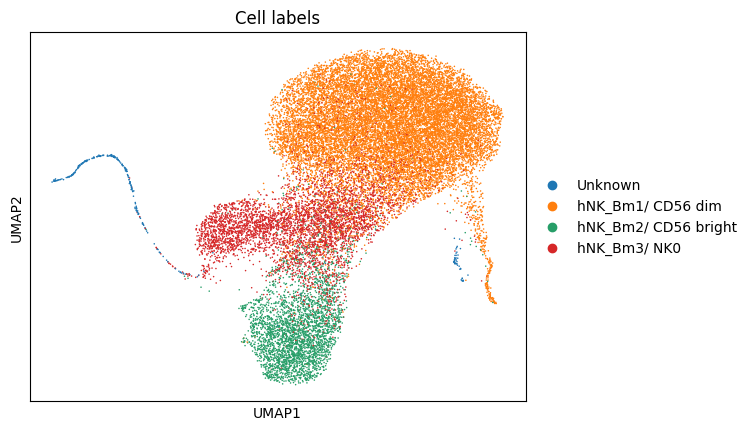

In [12]:
model.visualize_latent(color = ['Cell labels'])

In [19]:
vitae_new_clustering = adata_crinier.obs['vitae_new_clustering'].to_list()

In [20]:
adata_crinier.obs['vitae_new_clustering']= adata_crinier.obs['Cell labels'].to_list()

'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


IndexError: list index out of range

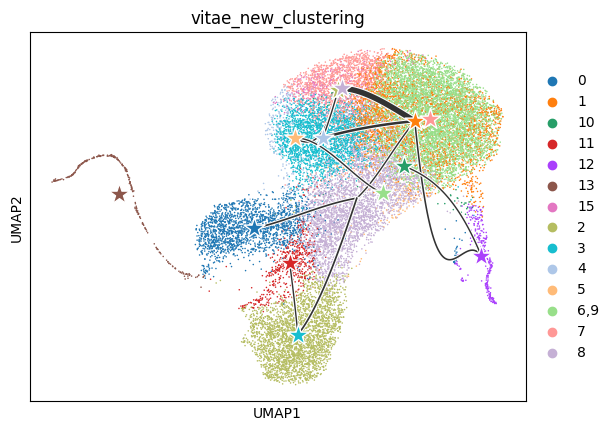

In [28]:
model.infer_backbone(cutoff = 0.1, no_loop = True, visualize = True)

In [24]:
model

Cell projection uncertainties stored as 'pseudotime' in self.adata.obs


/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/biocodingbarbie/anaconda3/envs/pyvitae-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


IndexError: list index out of range

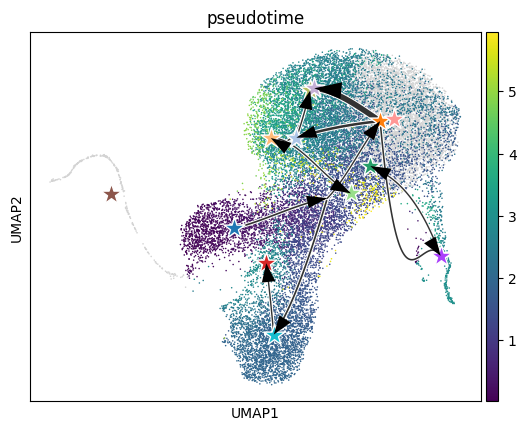

In [29]:
model.infer_trajectory(root = "0")

In [ ]:
# follow rest of tutorial for differential gene expression analysis
# https://github.com/jaydu1/VITAE/blob/master/tutorials/tutorial_dentate.ipynb